In [271]:
import pandas as pd 
import numpy as np
from collections import Counter
import gzip
import os
import subprocess

import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 
import subprocess

output_dir = '../output/significant_interactions/'

## Loading chromosome sizes

In [272]:
# Loading chromosome sizes 
chromsize_fn = '/gpfs/data01/glasslab/home/joreyna/projects/CSE283/imarge_project//ref/chromsize.hg38.txt'
chromsizes = pd.read_table(chromsize_fn, sep='\t', names=['chrom', 'size'])
chromsizes.set_index('chrom', inplace=True)

# Excluding non-human chromosomes 
chroms = list(range(1, 23)) + ['X', 'Y']
chroms = ['chr{}'.format(x) for x in chroms]
chromsizes = chromsizes[chromsizes.index.isin(chroms)]

In [273]:
chromsizes.head()

,size
chrom,
chr1,248956422
chr2,242193529
chr3,198295559
chr4,190214555
chr5,181538259


## Analyzing bin counts 

I want to look at the chromosomal pairs and see if if there is a pair worth plotting somehow. 

#### HEK

In [274]:
def analyze_chrom_counts(sig_ints):
    
    chrom_counts = sig_ints.groupby(['chr1', 'chr2']).apply(len).to_frame().reset_index()
    norm_counts = []
    for i, sr in chrom_counts.iterrows():
        chrA_size = chromsizes.loc[sr['chr1'], 'size']
        chrB_size = chromsizes.loc[sr['chr2'], 'size']
        norm_count = sr[0] / (chrA_size * chrB_size / 1000000**2)
        #norm_count = - np.log10(norm_count)
        norm_counts.append(norm_count)
    chrom_counts['norm_counts'] = norm_counts
    
    return(chrom_counts)



In [290]:
cell_type = 'hek'
data_dir = '../output/fithic/{}'.format(cell_type)
sig_ints = os.path.join(data_dir, 'FitHiC.spline_pass1.res40000.significances.txt.flt.gz')
sig_ints = pd.read_table(sig_ints)
chrom_counts_hek = analyze_chrom_counts(sig_ints)
chrom_counts_hek.head()

,chr1,chr2,0,norm_counts
0,chr1,chr1,10182,0.164281
1,chr1,chr10,1977,0.059352
2,chr1,chr11,2178,0.064762
3,chr1,chr12,1977,0.059585
4,chr1,chr13,1270,0.044606


In [291]:
sig_ints.shape

(498727, 9)

In [276]:
particl_hek = sig_ints[(sig_ints.chr1 == 'chr2') & \
         (sig_ints.fragmentMid1 >= 85537467 - 40000) & (sig_ints.fragmentMid1 <= 85538886 + 40000)]

In [289]:
particl_hek

,chr1,fragmentMid1,chr2,fragmentMid2,contactCount,p-value,q-value,bias1,bias2
48962,chr2,85520000,chr1,156760000,2,4.930974e-15,0.000005,1.0,1.0
51464,chr2,85520000,chr2,239800000,2,4.317319e-11,0.014656,1.0,1.0
54913,chr2,85520000,chr3,141240000,2,4.930974e-15,0.000005,1.0,1.0
54914,chr2,85520000,chr3,196400000,2,4.930974e-15,0.000005,1.0,1.0
55655,chr2,85520000,chr4,3040000,2,4.930974e-15,0.000005,1.0,1.0
55656,chr2,85520000,chr4,140720000,2,4.930974e-15,0.000005,1.0,1.0
56855,chr2,85520000,chr6,30880000,2,4.930974e-15,0.000005,1.0,1.0
58598,chr2,85520000,chr9,85960000,2,4.930974e-15,0.000005,1.0,1.0
59141,chr2,85520000,chr10,130200000,2,4.930974e-15,0.000005,1.0,1.0
60778,chr2,85520000,chr13,67280000,2,4.930974e-15,0.000005,1.0,1.0


In [278]:
chrom_counts_hek.norm_counts.describe()

count    530.000000
mean       0.061751
std        0.084521
min        0.000112
25%        0.016796
50%        0.028159
75%        0.062298
max        1.007932
Name: norm_counts, dtype: float64

In [279]:
chrom_matrix_hek = chrom_counts_hek.pivot(index='chr1', columns='chr2', values='norm_counts')
chrom_matrix_hek = chrom_matrix_hek.loc[chroms, chroms]
chrom_matrix_hek = chrom_matrix_hek.fillna(0)

/gpfs/data01/glasslab/home/joreyna/.conda/envs/tf_binding_nnet/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


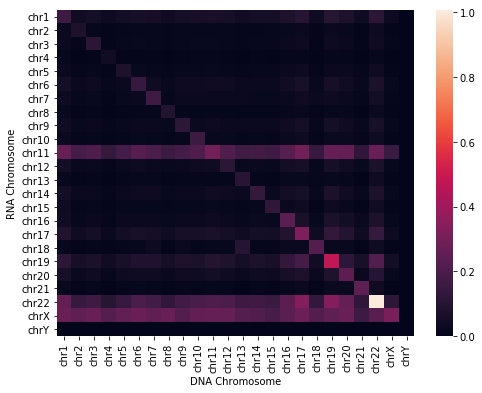

In [280]:
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(chrom_matrix_hek, ax=ax)

ax.set_ylabel('RNA Chromosome')
ax.set_xlabel('DNA Chromosome');

fn = os.path.join(output_dir, '{}_significant_interactions_heatmap.png'.format(cell_type))
fig.savefig(fn, dpi=200)

### HFF

In [292]:
cell_type = 'hff'
data_dir = '../output/fithic/{}'.format(cell_type)
sig_ints = os.path.join(data_dir, 'FitHiC.spline_pass1.res40000.significances.txt.flt.gz')
sig_ints = pd.read_table(sig_ints)
chrom_counts_hff = analyze_chrom_counts(sig_ints)
chrom_counts_hff.head()

,chr1,chr2,0,norm_counts
0,chr1,chr1,4857,0.078365
1,chr1,chr10,1366,0.041009
2,chr1,chr11,1418,0.042164
3,chr1,chr12,1534,0.046233
4,chr1,chr13,856,0.030065


In [293]:
sig_ints.shape

(320741, 9)

In [282]:
particl_hff = sig_ints[(sig_ints.chr1 == 'chr2') & \
         (sig_ints.fragmentMid1 >= 85537467 - 40000) & (sig_ints.fragmentMid1 <= 85538886 + 40000)]
particl_hff

,chr1,fragmentMid1,chr2,fragmentMid2,contactCount,p-value,q-value,bias1,bias2
33880,chr2,85520000,chr2,218880000,2,6.579634e-11,0.010179,1.0,1.0
38611,chr2,85520000,chr5,160320000,2,1.677857e-14,0.000008,1.0,1.0
40938,chr2,85520000,chr8,73880000,2,1.677857e-14,0.000008,1.0,1.0
42144,chr2,85520000,chr10,17360000,2,1.677857e-14,0.000008,1.0,1.0
43528,chr2,85520000,chr12,840000,2,1.677857e-14,0.000008,1.0,1.0
45100,chr2,85520000,chr15,67080000,2,1.677857e-14,0.000008,1.0,1.0
45101,chr2,85520000,chr15,82760000,2,1.677857e-14,0.000008,1.0,1.0


In [283]:
chrom_counts_hff.norm_counts.describe()

count    573.000000
mean       0.031746
std        0.051924
min        0.000184
25%        0.006833
50%        0.014153
75%        0.037094
max        0.349072
Name: norm_counts, dtype: float64

In [284]:
chrom_matrix_hff = chrom_counts_hff.pivot(index='chr1', columns='chr2', values='norm_counts')
chrom_matrix_hff = chrom_matrix_hff.loc[chroms, chroms]
chrom_matrix_hff = chrom_matrix_hff.fillna(0)

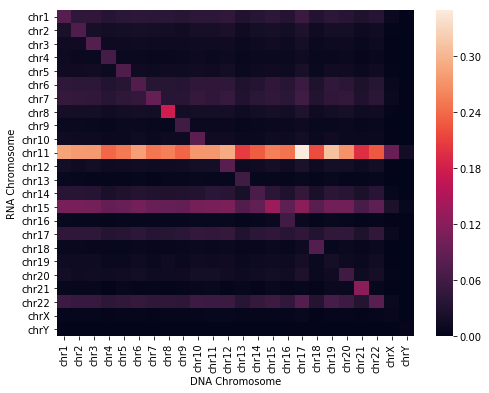

In [285]:
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(chrom_matrix_hff, ax=ax)

ax.set_ylabel('RNA Chromosome')
ax.set_xlabel('DNA Chromosome');

fn = os.path.join(output_dir, '{}_significant_interactions_heatmap.png'.format(cell_type))
fig.savefig(fn, dpi=200)

In [286]:
sig_ints.head()

,chr1,fragmentMid1,chr2,fragmentMid2,contactCount,p-value,q-value,bias1,bias2
0,chr1,600000,chr1,162560000,2,4.919350e-11,0.007639,1.0,1.0
1,chr1,600000,chr1,169520000,2,4.542896e-11,0.007062,1.0,1.0
2,chr1,840000,chr1,226440000,2,1.848807e-11,0.002890,1.0,1.0
3,chr1,1240000,chr1,156160000,2,5.302499e-11,0.008225,1.0,1.0
4,chr1,1360000,chr1,119600000,2,7.695194e-11,0.011864,1.0,1.0
